[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/MultiNEAs/blob/main/examples/probability_tutorial.ipynb)

# MultiNEAs: The `probability` Module Tutorial

This notebook demonstrates how to use the `multineas.probability` module for computing probability density functions (PDFs) in orbital element space and phase space (Cartesian coordinates), as well as integrating these PDFs over various regions.

The module provides:
- **OrbitElementsPDF**: PDF for orbital elements (q, e, i, Omega, w, M)
- **PhaseSpacePDF**: PDF for phase space (x, y, z, vx, vy, vz)
- **integrate**: Hypercube surface integral over 6D phase space
- **marginalize**: Box surface integral over 3D subspaces

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
try:
    from google.colab import drive
    %pip install -Uq multineas
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiNEAs.git

Not running in Colab, skipping installation


## Load the Package

Import `multineas.probability` and other required libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
import pandas as pd
import multineas.multimin as mm
warnings.filterwarnings("ignore")

from multineas.probability import (
    OrbitElementsPDF, 
    PhaseSpacePDF, 
    integrate, 
    marginalize,
    compute_jacobian_qei_to_QEI
)
from multineas.orbit import OrbitalCoordinates
from multineas.multimin import FitCMND
from multineas.plot import multineas_watermark
from multineas.util import Util

%matplotlib inline

Welcome to MultiNEAs v0.3.5


## Setup: Gravitational Parameter and Orbital Coordinates

First, we need to define the gravitational parameter and create instances of the coordinate transformation and PDF classes.

In [3]:
# Standard gravitational parameter in canonical units (AU^3/year^2)
deg = np.pi/180
AU_m = 1.496e11 #m
M_sun = 1.9891e30
G = 6.67430e-11 # m^3 / (kg s^2)
year = 365.25*24*3600 #s
mu = G * (1 / AU_m) ** 3 * M_sun * (year) ** 2

# Create orbital coordinates instance
oc = OrbitalCoordinates()

print(f"Gravitational parameter μ = {mu:.10f} AU³/year²")

Gravitational parameter μ = 39.4889416812 AU³/year²


In [4]:
#correct this to read the fit file 
df_neas=pd.read_json(Util.get_data("nea_extended.json.gz"))
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
df_neas["i"]=df_neas["i"]*deg
data_neas=np.array(df_neas[["q","e","i"]])

scales=[1.30,1.00,np.pi]
udata=np.zeros_like(data_neas)
for i in range(len(data_neas)):
    udata[i]=Util.t_if(data_neas[i],scales,Util.f2u)

F=mm.FitCMND(Ngauss=10,Nvars=3)
print(F.cmnd)

Composition of Ngauss = 10 gaussian multivariates of Nvars = 3 random variables:
    Weights: [0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002]
    Number of variables: 3
    Averages (μ): [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0

In [5]:
t = Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 2.9, 1.8, -1.7, 2.9, 1.8, -1.7, 2.8, 1.7, -1.7, 2.8, 1.7, -1.7, 2.8, 1.7, -1.7, 2.8, 1.7, -1.7, 2.8, 1.7, -1.7, 2.8, 1.7, -1.6, 2.8, 1.7, -1.6, 2.7, 1.7, -1.6, -1.2, -1.2, -1.8, -1.2, -1.2, -1.7, -1.3, -1.3, -1.7, -1.3, -1.3, -1.6, -1.3, -1.3, -1.6, -1.3, -1.3, -1.6, -1.3, -1.3, -1.5, -1.3, -1.3, -1.5, -1.3, -1.3, -1.4, -1.2, -1.3, -1.2, 4.2, 1.6, 1.8, 3.2, 2, 2.1, 2.6, 2.5, 2.1, 1.9, 2.8, 1.8, 1.3, 1.3, 2.3, 2, 2, 1.9, 1.5, 1.6, 1.8, 1.7, 1.7, 1.7, 1.5, 1.6, 1.7, 1.2, 1.4, 1.7]
	LogL/N: 5.517340636176077
Iter 1:
	Vars: [-1.4, 1.1, 0.81, -0.89, -1.9, 74, 2.3, 74, 1.7, 0.32, 3.1, 0.12, -1.9, 2.8, 0.68, -2.3, 2.4, 0.34, -2.2, 0.77, 0.032, -2.5, 0.5, 0.56, -4.7, 1.9, 0.41, -2.7, 1.4, 0.39, -2.6, 1.6, 0.35, -2.7, 1.4, 0.35, -2.8, 1.4, 0.39, -3, -1, -3.5, -1.7, -1.2, -2.5, -1.8, -1.6, -2.1, -2.1, -2.8, -2.4, -2.1, -2.8, -3.5, -1.6, -2.3, -2.3, -1.8, -3.4, -1.4, -2, -1.3, -1.9, -1.9, -1.5, -1.5, -1.6, -1, -1.5, -1.

In [6]:
F.save_fit('fit10.pkl')

In [8]:
F.save_fit?

Signature: F.save_fit(objfile=None, useprefix=True, myprefix=None)
Docstring:
Pickle the result of a fit.

Parameters
----------
objfile : str, optional
    Name of the file where the fit will be stored. If None, the name is set 
    by the routine as FitCMND.pkl.
useprefix : bool, optional
    Use a prefix in the filename of the pickle file (default True). 
    The prefix is normally {Ngauss}cmnd_{hash}.
myprefix : str, optional
    Custom prefix.
    
Examples
--------
If objfile="fit.pkl", the final filename will be fit-1mnd_asa33.pkl
File:      ~/dev/MultiNEAs/src/multineas/multimin.py
Type:      method

## Loading a Fitted CMND Model

To compute probability densities, we need a fitted Composed Multivariate Normal Distribution (CMND) model. This model is typically obtained by fitting orbital element data from Near-Earth Asteroids (NEAs).

**Note**: You'll need to provide the path to a fitted CMND model file (`.pkl`). If you don't have one, you can create it using the `multimin` module (see `multimin_tutorial.ipynb`).

In [9]:
fit_file = "./fit10-10cmndNone_3c234.pkl"
F = mm.FitCMND(fit_file)

## Part 1: OrbitElementsPDF Class

The `OrbitElementsPDF` class computes the probability density function in orbital element space: P_E_CMND(q, e, i, Omega, w, M).

### Understanding OrbitElementsPDF

The PDF is computed as:
- **P_qei(q, e, i)**: CMND PDF for the orbital elements (q, e, i)
- **P_Omega_w_M**: Uniform distribution over angles (Omega, w, M) = 1/(2π)³

The class transforms orbital elements from finite intervals to unbound space using the `Util.f2u` transformation.

In [10]:
# Create OrbitElementsPDF instance
# Default scales: [1.30, 1.00, np.pi] for [q, e, i]
oepdf = OrbitElementsPDF(F)

# You can also specify custom scales
# oepdf = OrbitElementsPDF(F, scales=[1.35, 1.00, np.pi])

print("OrbitElementsPDF instance created")
print(f"Scales: {oepdf.scales}")

OrbitElementsPDF instance created
Scales: [1.3, 1.0, 3.141592653589793]


### Computing PDF for Orbital Elements

Let's compute the PDF for specific orbital elements:

In [14]:
# Example 1: Circular orbit at 1 AU
q1 = 1.0  # AU
e1 = 0.0  # Circular
i1 = np.pi / 6  # 30 degrees

prob1 = oepdf.compute_p_e_cmnd(q1, e1, i1)
print(f"Example 1 - Circular orbit:")
print(f"  q = {q1:.2f} AU, e = {e1:.2f}, i = {i1*180/np.pi:.1f}°")
print(f"  PDF = {prob1:.6e}")

# Example 2: Elliptical orbit
q2 = 0.5  # AU
e2 = 0.5  # Moderate eccentricity
i2 = np.pi / 4  # 45 degrees

prob2 = oepdf.compute_p_e_cmnd(q2, e2, i2)
print(f"\nExample 2 - Elliptical orbit:")
print(f"  q = {q2:.2f} AU, e = {e2:.2f}, i = {i2*180/np.pi:.1f}°")
print(f"  PDF = {prob2:.6e}")

# Example 3: High inclination orbit
q3 = 0.8  # AU
e3 = 0.3
i3 = np.pi / 2  # 90 degrees (polar orbit)

prob3 = oepdf.compute_p_e_cmnd(q3, e3, i3)
print(f"\nExample 3 - High inclination orbit:")
print(f"  q = {q3:.2f} AU, e = {e3:.2f}, i = {i3*180/np.pi:.1f}°")
print(f"  PDF = {prob3:.6e}")

Example 1 - Circular orbit:
  q = 1.00 AU, e = 0.00, i = 30.0°
  PDF = 0.000000e+00

Example 2 - Elliptical orbit:
  q = 0.50 AU, e = 0.50, i = 45.0°
  PDF = 1.640314e-05

Example 3 - High inclination orbit:
  q = 0.80 AU, e = 0.30, i = 90.0°
  PDF = 6.265993e-07


### Visualizing PDF in Orbital Element Space

Let's create a 2D visualization of the PDF as a function of q and e for a fixed inclination:

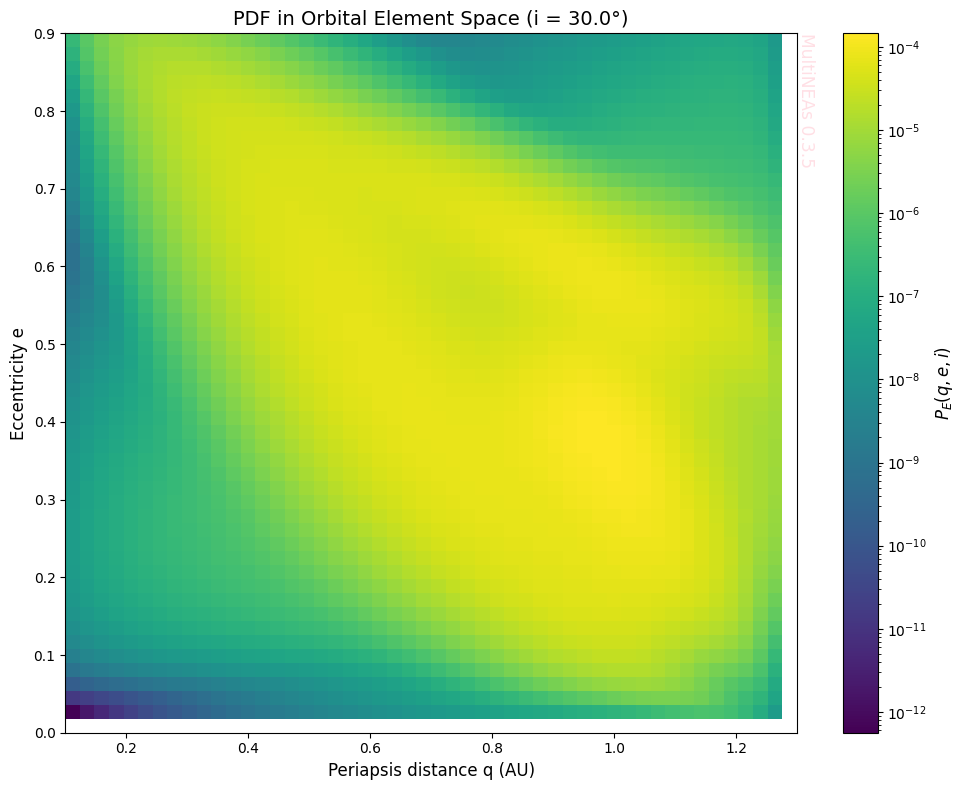

In [12]:
# Create a grid of q and e values
q_vals = np.linspace(0.1, 1.3, 50)
e_vals = np.linspace(0.0, 0.9, 50)
i_fixed = np.pi / 6  # 30 degrees

# Compute PDF for each point
pdf_grid = np.zeros((len(e_vals), len(q_vals)))
for i, e in enumerate(e_vals):
    for j, q in enumerate(q_vals):
        pdf_grid[i, j] = oepdf.compute_p_e_cmnd(q, e, i_fixed)

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    pdf_grid,
    extent=[q_vals.min(), q_vals.max(), e_vals.min(), e_vals.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis',
    norm=LogNorm(vmin=np.nanmin(pdf_grid[pdf_grid > 0]), vmax=np.nanmax(pdf_grid))
)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$P_E(q, e, i)$", fontsize=12)

ax.set_xlabel("Periapsis distance q (AU)", fontsize=12)
ax.set_ylabel("Eccentricity e", fontsize=12)
ax.set_title(f"PDF in Orbital Element Space (i = {i_fixed*180/np.pi:.1f}°)", fontsize=14)

# Add watermark
multineas_watermark(ax)

plt.tight_layout()
plt.show()

## Part 2: PhaseSpacePDF Class

The `PhaseSpacePDF` class computes the probability density function in Cartesian phase space: P_X_CMND(x, y, z, vx, vy, vz).

### Understanding PhaseSpacePDF

The PDF in phase space is computed by:
1. Transforming Cartesian coordinates to orbital elements
2. Computing the PDF in orbital element space
3. Applying the Jacobian transformation to account for the coordinate change

The transformation involves:
- **Jacobian X→E**: Transformation from Cartesian to orbital elements
- **Jacobian qei→QEI**: Transformation from finite intervals to unbound space

In [13]:
# Create PhaseSpacePDF instance
# Parameters: q_max, e_max, i_max define the maximum values for the transformation
q_max = 1.30  # Maximum perihelion distance (AU)
e_max = 1.0   # Maximum eccentricity
i_max = np.pi  # Maximum inclination (radians)

pspdf = PhaseSpacePDF(
    orbit_coords=oc,
    orbit_elements_pdf=oepdf,
    q_max=q_max,
    e_max=e_max,
    i_max=i_max,
    mu=mu
)

print("PhaseSpacePDF instance created")
print(f"Parameters: q_max={q_max}, e_max={e_max}, i_max={i_max:.2f} rad ({i_max*180/np.pi:.1f}°)")

PhaseSpacePDF instance created
Parameters: q_max=1.3, e_max=1.0, i_max=3.14 rad (180.0°)


### Computing PDF for Single Points in Phase Space

Let's compute the PDF at specific points in phase space:

In [14]:
# Example 1: Circular orbit at 1 AU in the XY plane
x1, y1, z1 = 1.0, 0.1, 0.0
vx1, vy1, vz1 = 0.01, 6.28, 0.01  # Circular velocity ~ 2π AU/year

prob1 = pspdf.compute_p_x_cmnd(x1, y1, z1, vx1, vy1, vz1)
print(f"Example 1 - Circular orbit at 1 AU:")
print(f"  Position: ({x1:.2f}, {y1:.2f}, {z1:.2f}) AU")
print(f"  Velocity: ({vx1:.2f}, {vy1:.2f}, {vz1:.2f}) AU/day")
print(f"  PDF = {prob1:.6e}")

# Example 2: Elliptical orbit
x2, y2, z2 = 0.5, 0.5, 0.0
vx2, vy2, vz2 = 0.01, 8.0, 0.01

prob2 = pspdf.compute_p_x_cmnd(x2, y2, z2, vx2, vy2, vz2)
print(f"\nExample 2 - Elliptical orbit:")
print(f"  Position: ({x2:.2f}, {y2:.2f}, {z2:.2f}) AU")
print(f"  Velocity: ({vx2:.2f}, {vy2:.2f}, {vz2:.2f}) AU/day")
print(f"  PDF = {prob2:.6e}")

Example 1 - Circular orbit at 1 AU:
  Position: (1.00, 0.10, 0.00) AU
  Velocity: (0.01, 6.28, 0.01) AU/day
  PDF = 8.576654e-02

Example 2 - Elliptical orbit:
  Position: (0.50, 0.50, 0.00) AU
  Velocity: (0.01, 8.00, 0.01) AU/day
  PDF = 3.493277e-06


### Computing PDF for Arrays of Points

The `compute_p_x_cmnd` method supports vectorized operations, allowing you to compute PDFs for multiple points efficiently:

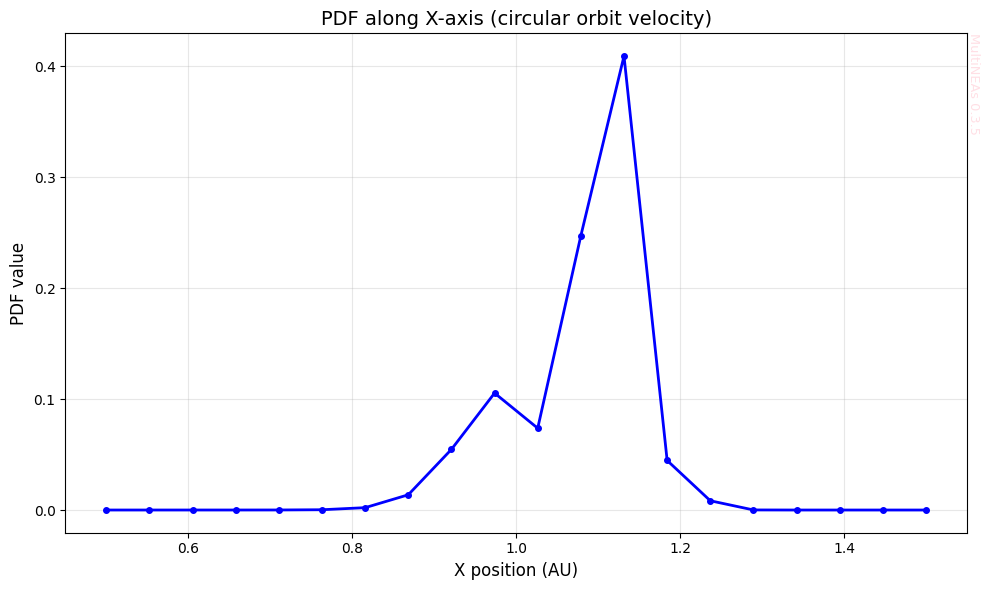

In [22]:
# Create an array of positions along the X-axis
x_vals = np.linspace(0.5, 1.5, 20)
y_vals = np.zeros_like(x_vals)
z_vals = np.zeros_like(x_vals)

# Fixed velocity (circular orbit velocity)
vx_vals = np.zeros_like(x_vals) + 0.01
vy_vals = np.full_like(x_vals, 0.95*6.28)  # Circular velocity
vz_vals = np.zeros_like(x_vals) + 0.01

# Compute PDF for all points
probs = pspdf.compute_p_x_cmnd(x_vals, y_vals, z_vals, vx_vals, vy_vals, vz_vals)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_vals, probs, 'b-', linewidth=2, marker='o', markersize=4)
ax.set_xlabel("X position (AU)", fontsize=12)
ax.set_ylabel("PDF value", fontsize=12)
ax.set_title("PDF along X-axis (circular orbit velocity)", fontsize=14)
#ax.set_yscale('log')
ax.grid(True, alpha=0.3)

multineas_watermark(ax)
plt.tight_layout()
plt.show()

## Part 3: Integration Functions

The module provides two integration functions:
- **`integrate`**: Hypercube surface integral over 6D phase space
- **`marginalize`**: Box surface integral over 3D subspaces (position or velocity)

Both functions use Gauss-Legendre quadrature for numerical integration.

### Using `marginalize` Function

The `marginalize` function integrates over a 3D box while keeping the other 3 dimensions fixed. This is useful for computing marginal distributions.

**Example**: Integrate over velocity space with fixed position

In [23]:
# Fixed position
fixed_position = [1.0, 0.0, 0.0]  # AU

# Velocity box center and widths
velocity_center = [0.0, 6.28, 0.0]  # AU/day
velocity_widths = [0.5, 0.5, 0.5]  # AU/day

max_elements = [q_max, e_max, i_max]

# Integrate over velocity space
integral_v = marginalize(
    center=velocity_center,
    widths=velocity_widths,
    fixed_values=fixed_position,
    max_elements=max_elements,
    pdf=pspdf,
    integrate_over='velocity',
    n_points=6  # Number of quadrature points per dimension
)

print(f"Fixed position: {fixed_position} AU")
print(f"Velocity box center: {velocity_center} AU/day")
print(f"Velocity box widths: {velocity_widths} AU/day")
print(f"Integral over velocity space: {integral_v:.6e}")

Fixed position: [1.0, 0.0, 0.0] AU
Velocity box center: [0.0, 6.28, 0.0] AU/day
Velocity box widths: [0.5, 0.5, 0.5] AU/day
Integral over velocity space: 7.156733e-03


**Example**: Integrate over position space with fixed velocity

In [24]:
# Fixed velocity
fixed_velocity = [0.0, 6.28, 0.0]  # AU/day

# Position box center and widths
position_center = [1.0, 0.0, 0.0]  # AU
position_widths = [0.1, 0.1, 0.1]  # AU

# Integrate over position space
integral_r = marginalize(
    center=position_center,
    widths=position_widths,
    fixed_values=fixed_velocity,
    max_elements=max_elements,
    pdf=pspdf,
    integrate_over='position',
    n_points=6
)

print(f"Fixed velocity: {fixed_velocity} AU/day")
print(f"Position box center: {position_center} AU")
print(f"Position box widths: {position_widths} AU")
print(f"Integral over position space: {integral_r:.6e}")

Fixed velocity: [0.0, 6.28, 0.0] AU/day
Position box center: [1.0, 0.0, 0.0] AU
Position box widths: [0.1, 0.1, 0.1] AU
Integral over position space: 4.887797e-05


### Using `integrate` Function

The `integrate` function computes the hypercube surface integral over all 6 dimensions of phase space. This is more computationally expensive but provides the full probability over a 6D region.

In [25]:
# Define a small hypercube in phase space
center = [1.0, 0.0, 0.0, 0.0, 6.28, 0.0]  # [x, y, z, vx, vy, vz]
widths = [0.05, 0.05, 0.05, 0.1, 0.1, 0.1]  # Small region

# Compute integral (using fewer points for faster computation)
integral_6d = integrate(
    center=center,
    widths=widths,
    max_elements=max_elements,
    pdf=pspdf,
    n_points=4  # Reduced for demonstration (use 6-8 for better accuracy)
)

print(f"6D hypercube integral:")
print(f"  Center: {center}")
print(f"  Widths: {widths}")
print(f"  Integral: {integral_6d:.6e}")
print(f"\nNote: This represents the probability of finding an asteroid")
print(f"      within this 6D region of phase space.")

6D hypercube integral:
  Center: [1.0, 0.0, 0.0, 0.0, 6.28, 0.0]
  Widths: [0.05, 0.05, 0.05, 0.1, 0.1, 0.1]
  Integral: 1.998728e-08

Note: This represents the probability of finding an asteroid
      within this 6D region of phase space.


### Creating a Probability Map

Let's create a 2D probability map by integrating over velocity space for different positions:

In [26]:
# Define grid
x_min, x_max = -2, 2
y_min, y_max = -2, 2
dx, dy, dz = 0.1, 0.1, 0.1

x_vals = np.arange(x_min, x_max + dx, dx)
y_vals = np.arange(y_min, y_max + dy, dy)

# Fixed z and velocity
z_fixed = 0.0
vx_fixed, vy_fixed, vz_fixed = 0.0, 6.28, 0.0
fixed_velocity = [vx_fixed, vy_fixed, vz_fixed]

position_widths = np.array([dx, dy, dz])

# Compute probability map
print("Computing probability map...")
probability_map = np.zeros((len(y_vals), len(x_vals)))

for i, y_c in enumerate(y_vals):
    for j, x_c in enumerate(x_vals):
        position_center = [x_c, y_c, z_fixed]
        
        try:
            prob_value = marginalize(
                center=position_center,
                widths=position_widths,
                fixed_values=fixed_velocity,
                max_elements=max_elements,
                pdf=pspdf,
                integrate_over='position',
                n_points=4  # Reduced for faster computation
            )
            probability_map[i, j] = prob_value
        except Exception as err:
            probability_map[i, j] = np.nan

print("Probability map computed!")

Computing probability map...
Probability map computed!


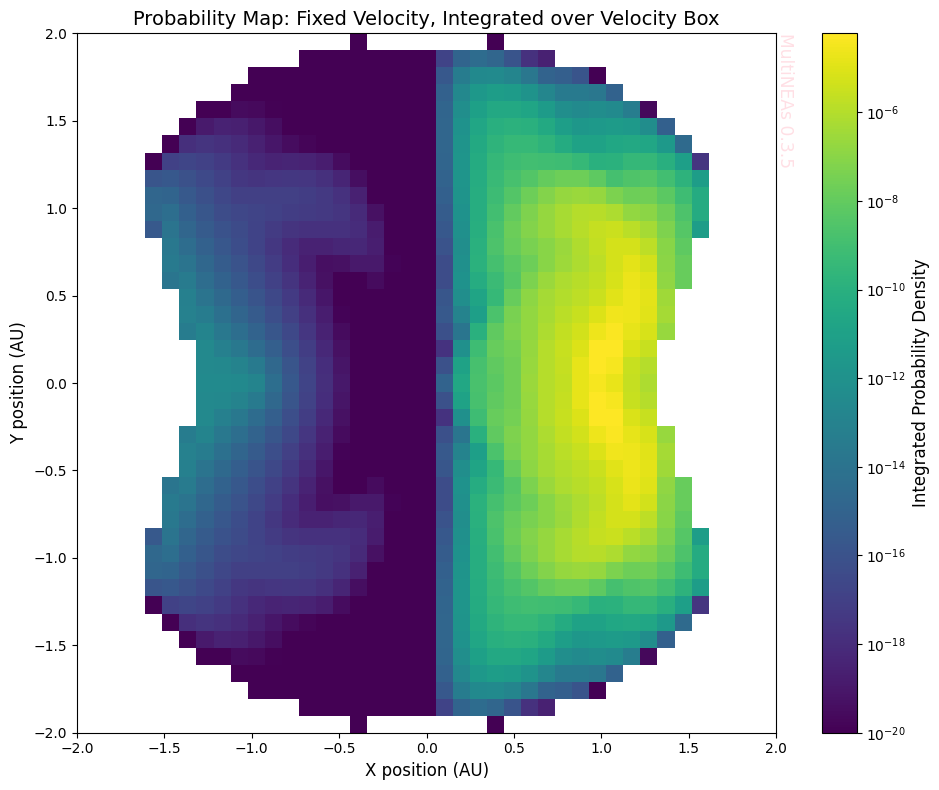

In [36]:
# Plot the probability map
fig, ax = plt.subplots(figsize=(10, 8))

vmin = 1e-20
vmax = np.nanmax(probability_map)

im = ax.imshow(
    probability_map,
    extent=[x_min, x_max, y_min, y_max],
    origin='lower',
    cmap='viridis',
    interpolation='nearest',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Integrated Probability Density", fontsize=12)

ax.set_xlabel("X position (AU)", fontsize=12)
ax.set_ylabel("Y position (AU)", fontsize=12)
ax.set_title("Probability Map: Fixed Velocity, Integrated over Velocity Box", fontsize=14)
ax.set_aspect('equal', adjustable='box')

multineas_watermark(ax)
plt.tight_layout()
fig.savefig('./gallery/marginal-space-map.png', dpi=300)
plt.show()

In [32]:
import plotly.express as px
import numpy as np

# Log-transform the map to replicate LogNorm behavior
log_probability_map = np.log10(probability_map)
vmin_log = -20
vmax_log = np.nanmax(log_probability_map)

fig = px.imshow(
    log_probability_map,
    x=np.linspace(x_min, x_max, probability_map.shape[1]),
    y=np.linspace(y_min, y_max, probability_map.shape[0]),
    origin='lower',
    color_continuous_scale='Viridis',
    range_color=[vmin_log, vmax_log]
)

fig.show()

## Part 4: Jacobian Transformation

The `compute_jacobian_qei_to_QEI` function computes the Jacobian matrix for the transformation from finite intervals (q, e, i) to unbound space (Q, E, I). This is used internally by `PhaseSpacePDF` but can also be used independently.

In [35]:
# Compute Jacobian for a specific point
q, e, i = 0.5, 0.3, np.pi/4

J = compute_jacobian_qei_to_QEI(q, e, i, q_max, e_max, i_max)

print(f"Orbital elements: q={q:.2f} AU, e={e:.2f}, i={i*180/np.pi:.1f}°")
print(f"\nJacobian matrix:")
print(J)
print(f"\nJacobian determinant: {np.linalg.det(J):.6e}")
print(f"\nNote: The Jacobian accounts for the transformation from")
print(f"      finite intervals [0, max] to unbound space [-∞, +∞]")

Orbital elements: q=0.50 AU, e=0.30, i=45.0°

Jacobian matrix:
[[3.25       0.         0.        ]
 [0.         4.76190476 0.        ]
 [0.         0.         1.69765273]]

Jacobian determinant: 2.627320e+01

Note: The Jacobian accounts for the transformation from
      finite intervals [0, max] to unbound space [-∞, +∞]


## Summary

This tutorial demonstrated the use of the `multineas.probability` module:

1. **OrbitElementsPDF**: Computes PDFs in orbital element space (q, e, i, Omega, w, M)
   - Uses CMND models fitted to NEA data
   - Assumes uniform distribution over angles (Omega, w, M)

2. **PhaseSpacePDF**: Computes PDFs in Cartesian phase space (x, y, z, vx, vy, vz)
   - Transforms coordinates using `OrbitalCoordinates`
   - Applies Jacobian transformations for coordinate changes
   - Validates orbits (NEA classification, elliptical orbits)

3. **Integration Functions**:
   - `integrate`: Full 6D hypercube integration
   - `marginalize`: 3D box integration (position or velocity space)

4. **Jacobian Functions**:
   - `compute_jacobian_qei_to_QEI`: Transformation from finite to unbound intervals

### Key Applications

- **Population Analysis**: Understanding the distribution of NEAs in phase space
- **Impact Probability**: Computing probabilities of asteroids in specific regions
- **Statistical Studies**: Analyzing orbital element distributions
- **Marginal Distributions**: Computing probability densities in subspaces

### Best Practices

- Use appropriate quadrature points (`n_points`) for balance between accuracy and speed
- Validate that orbits are NEAs (q ≤ 1.3 AU) and elliptical (e < 1.0)
- For large-scale computations, consider vectorized operations
- Check for NaN values in results, which may indicate invalid orbits or numerical issues

---

**MultiNEAs** - Numerical tools for near-earth asteroid dynamics and population

© 2026 Jorge I. Zuluaga and Juanita A. Agudelo